# Thinned Data Statistical Analysis

We started collecting about 20x fewer tweets in the middle of 06/25 in order to reduce file size and clumsiness. The original data only captures about 1% of Twitter traffic. We want to test and see if the reduced files are statistically different from the larger data set.

In order to do so, we have a few options for statistical tests. Two common tests that we want to run are:
1. **ANOVA Test** - Analysis of variance test. This test analyzes the difference between the means of more than two groups.
2. **Independent Samples t-test** - This test analyzes the difference between the population means of two groups.

The difference between tests exists in how we define a "group" of data. It makes sense to define two groups: full data vs. reduced data which suggests a t-test. However, we could create more groups for an ANOVA test by separating by day. Therefore, group 1 could be 06/24 full data, group 2 could be 06/26 reduced data, group 3 - 06/27 reduced data, etc.

We want to test a few dependent variables in order to really check for statistical difference. I propose the following set of dependent variables:
- ratio of tweets vs. (retweets, quotes, replies)
- ratio of retweets vs. (tweets, quotes, replies)
- ratio of quotes vs. (tweets, retweets, replies)
- ratio of replies vs. (tweets, retweets, quotes)
- ratio of common stop words vs. all other words
- ratio of selected keywords (Trump, Biden) vs. all other words ratio

Our thinned tweets do not include the tweet's timestamp. Therefore, I plan to split each day of data into data points by grouping by a certain size. Ideally I would like > 30 tweets in a chunk to assume normality by the Central Limit Theorem.

We can assume independent samples because our data will be examined from different days. Therefore, they will be different tweets. We also have a random sample due to how Twitter allows us to collect data.

For the t-test, our null and alternative hypotheses are as follows:
$$H_0 : \mu_1 = \mu_2$$
$$H_1 : \mu_1 \neq \mu_2$$
The null states that the population means are equal, and the alternative states that the population means are different.

## Imports

In [2]:
# These paths should be updated so that no files need to be downloaded...
import os
import sys
shared_path = '/Users/sarah/Downloads/TwitterResearch2020'
sys.path.append(shared_path)
import thinned_tweet_obj
import general_utilities

In [3]:
import json
import pickle
import subprocess
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Normality investigation


In [23]:
def load_and_print_len(filename):
    thin_objs = general_utilities.read_pkl(filename)
    print(len(thin_objs))
    return thin_objs

In [24]:
# Data from June 26, the first full day of reduced tweets
tweets_0626 = load_and_print_len('combined_tweets-2020-06-26.pkl')

154000


In [30]:
# Data from August 26, reduced tweets, but sleep is smaller than 0626 (so we should have more data)
tweets_0826 = load_and_print_len('combined_tweets-2020-08-26.pkl')

269000


In [33]:
# Data from August 28, reduced tweets, starts keeping track of favorites
tweets_0828 = load_and_print_len('combined_tweets-2020-08-28.pkl')

542000


In [34]:
# Data from August 29, reduced tweets
tweets_0829 = load_and_print_len('combined_tweets-2020-08-29.pkl')

274000


In [26]:
# Data from September 1, reduced tweets, has favorites
tweets_0901 = load_and_print_len('combined_tweets-2020-09-01.pkl')

280000


In [75]:
# Data from June 24 is the larger data set of tweets
tweets_0624 = load_and_print_len('/Users/sarah/Downloads/combined_tweets-2020-06-24.pkl')

4784443


In [6]:
def append_ratio(mean_tracker, numerator, denom):
    '''
    @param mean_tracker: List of means
    @param numerator: Numerator for the new mean to calculate
    @param denom: Denominator for the new mean to calculate
    '''
    mean_tracker.append(numerator / denom)
    
def get_tweet_type_distribution(obj_lst):
    '''
    Divide a day's worth of combined_tweets into `total_groups` and find the relevant ratios per group 
    to investigate the distribution of tweet types.
    
    @param obj_lst: List of combined, thinned tweet objects read from the pkl files
    @return: Three lists of length approximately 'total_groups' containing the population means for each 
    group. The first list contains the ratio of retweets, the second contains the ratio of replies, and 
    the third contains the ratio of quotes.
    '''
    lst_len = len(obj_lst)
    # One group per minute of the day (we might want to pick a smarter value than this)
    total_groups = 60 * 24
    group_size = lst_len // total_groups
    # 'xxx_mean_tracker' tracks the ratio of xxx vs. [(tweets, retweets, quotes, replies) - xxx]
    retweet_mean_tracker = []
    reply_mean_tracker = []
    quote_mean_tracker = []
    
    tweet_count = 0
    retweet_count = 0
    reply_count = 0
    quote_count = 0
    for thin_obj in obj_lst:
        if tweet_count == group_size:
            append_ratio(retweet_mean_tracker, retweet_count, tweet_count)
            append_ratio(reply_mean_tracker, reply_count, tweet_count)
            append_ratio(quote_mean_tracker, quote_count, tweet_count)
            
            tweet_count = 0
            retweet_count = 0
            reply_count = 0
            quote_count = 0
        
        tweet_count += 1
        if thin_obj.is_retweet: retweet_count += 1
        if thin_obj.is_reply(): reply_count += 1
        if thin_obj.quote_status: quote_count += 1
            
    return retweet_mean_tracker, reply_mean_tracker, quote_mean_tracker

In [7]:
def get_dist_stats(obj_lst):
    '''
    Print the percentage of retweets, replies, and quotes per one day of combined_tweets.
    
    @param obj_lst: List of combined, thinned tweet objects read from the pkl files
    @return: Three lists of length approximately 'total_groups' containing the population means for each 
    group. The first list contains the ratio of retweets, the second contains the ratio of replies, and 
    the third contains the ratio of quotes.
    '''
    retweet_means, reply_means, quote_means = get_tweet_type_distribution(obj_lst)
    print("percentage retweets: ", np.array(retweet_means).mean())
    print("percentage replies: ", np.array(reply_means).mean())
    print("percentage quotes: ", np.array(quote_means).mean())
    return retweet_means, reply_means, quote_means

In [76]:
print("----- Thinned data stats -----")
retweet_means_thin, reply_means_thin, quote_means_thin = get_dist_stats(tweets_0626)

print("----- Full data stats -----")
retweet_means_full, reply_means_full, quote_means_full = get_dist_stats(tweets_0624)

----- Thinned data stats -----
percentage retweets:  0.6245257029991164
percentage replies:  0.23136597536254483
percentage quotes:  0.2569520245334997
----- Full data stats -----
percentage retweets:  0.6217230249515018
percentage replies:  0.2245904826409793
percentage quotes:  0.25006124991638234


**Note:** There appears to be an error with the `is_reply` field.

In the future, we may want to consider different ways of constructing groups within a day.

In [61]:
print("----- Thinned data stats, 08/26 -----")
retweet_means_0826, reply_means_0826, quote_means_0826 = get_dist_stats(tweets_0826)

print("----- Thinned data stats, 08/28 -----")
retweet_means_0828, reply_means_0828, quote_means_0828 = get_dist_stats(tweets_0828)

print("----- Thinned data stats, 08/29 -----")
retweet_means_0829, reply_means_0829, quote_means_0829 = get_dist_stats(tweets_0829)

print("----- Thinned data stats, 09/01 -----")
retweet_means_0901, reply_means_0901, quote_means_0901 = get_dist_stats(tweets_0901)

----- Thinned data stats, 08/26 -----
percentage retweets:  0.6146655958595457
percentage replies:  0.2469028391261024
percentage quotes:  0.22214042445604484
----- Thinned data stats, 08/28 -----
percentage retweets:  0.6152679138305255
percentage replies:  0.24712263942002452
percentage quotes:  0.24227966689798752
----- Thinned data stats, 08/29 -----
percentage retweets:  0.6433170304401781
percentage replies:  0.22170961384042634
percentage quotes:  0.2496605591649025
----- Thinned data stats, 09/01 -----
percentage retweets:  0.6227039886833702
percentage replies:  0.23751705710468596
percentage quotes:  0.2300798022447507


## Perform t-test

In [71]:
# https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

def t_test(data_lst_thin, data_lst_full, alpha = 0.05):
    '''
    Runs a t-test to compare the population means between the reduced and larger combined_tweet data.
    
    @param data_lst_thin: List of population means from the reduced tweet data.
    @param data_lst_full: List of population means from the larger tweet data.
    '''
    N = min(len(data_lst_thin), len(data_lst_full))
    data_lst_thin = np.array(data_lst_thin[:N])
    data_lst_full = np.array(data_lst_full[:N])
    var_thin = data_lst_thin.var(ddof=1)
    var_full = data_lst_full.var(ddof=1)
    st_dev = np.sqrt((var_thin + var_full) / 2)
    t_stat = (data_lst_thin.mean() - data_lst_full.mean()) / (st_dev * np.sqrt(2 / N))
    # Degrees of freedom
    df = 2 * N - 2
    # p-value after comparison with the Student t distribution
    p = 1 - stats.t.cdf(t_stat, df=df)
    
    print("t_stat = " + str(t_stat))
    p_val = 2 * p
    print("p_val = " + str(p_val))
    # Reject the null if the p-value is < alpha (0.05)
    if p_val < alpha:
        print("REJECT - evidence of statistical difference")
    else:
        print("ACCEPT - not statistically different")

In [77]:
print("----- retweets t-test -----")
t_test(retweet_means_thin, retweet_means_full)
print("----- replies t-test -----")
t_test(reply_means_thin, reply_means_full)
print("----- quotes t-test -----")
t_test(quote_means_thin, quote_means_full)

----- retweets t-test -----
t_stat = 1.1778701790635677
p_val = 0.2389457525069174
ACCEPT - not statistically different
----- replies t-test -----
t_stat = 2.6016592334895727
p_val = 0.009324938356913837
REJECT - evidence of statistical difference
----- quotes t-test -----
t_stat = 3.5594451365156825
p_val = 0.0003776509718413923
REJECT - evidence of statistical difference


We have to throw replies out of our analysis because of the error in the `is_reply` field. Otherwise, we can conclude that the ratio of retweets are not statistically different between the reduced and larger data (since our p-value is greater than $\alpha = 0.05$. We do reject the null for the ratio of quotes, instead, concluding that the ratio of quotes *are* statistically different between the reduced and larger data.

In [73]:
# t-tests of thinned vs. slightly larger data (after 08/28)
print("----- retweets t-test 06/26 vs. 08/28 -----")
t_test(retweet_means_thin, retweet_means_0828)
print("----- replies t-test 06/26 vs. 08/28 -----")
t_test(reply_means_thin, reply_means_0828)
print("----- quotes t-test 06/26 vs. 08/28 -----")
t_test(quote_means_thin, quote_means_0828)

print()

print("----- retweets t-test 06/26 vs. 08/29 -----")
t_test(retweet_means_thin, retweet_means_0829)
print("----- replies t-test 06/26 vs. 08/29 -----")
t_test(reply_means_thin, reply_means_0829)
print("----- quotes t-test 06/26 vs. 08/29 -----")
t_test(quote_means_thin, quote_means_0829)

print()

print("----- retweets t-test 06/26 vs. 09/01 -----")
t_test(retweet_means_thin, retweet_means_0901)
print("----- replies t-test 06/26 vs. 09/01 -----")
t_test(reply_means_thin, reply_means_0901)
print("----- quotes t-test 06/26 vs. 09/01 -----")
t_test(quote_means_thin, quote_means_0901)

----- retweets t-test 06/26 vs. 08/28 -----
t_stat = 3.388962766346691
p_val = 0.0007110112795540857
REJECT - evidence of statistical difference
----- replies t-test 06/26 vs. 08/28 -----
t_stat = -5.083602455917209
p_val = 1.9999996059574696
ACCEPT - not statistically different
----- quotes t-test 06/26 vs. 08/28 -----
t_stat = 6.92232717976874
p_val = 5.455413898403094e-12
REJECT - evidence of statistical difference

----- retweets t-test 06/26 vs. 08/29 -----
t_stat = -7.467324498840739
p_val = 1.999999999999892
ACCEPT - not statistically different
----- replies t-test 06/26 vs. 08/29 -----
t_stat = 3.358674377760966
p_val = 0.0007933522461209819
REJECT - evidence of statistical difference
----- quotes t-test 06/26 vs. 08/29 -----
t_stat = 3.3404933544662962
p_val = 0.0008469489732880753
REJECT - evidence of statistical difference

----- retweets t-test 06/26 vs. 09/01 -----
t_stat = 0.5653514721716401
p_val = 0.5718787017679516
ACCEPT - not statistically different
----- replies t-t

In [79]:
# t-tests of full vs. slightly thinned data (after 08/28)
print("----- retweets t-test full vs. 08/28 -----")
t_test(retweet_means_full, retweet_means_0828)
print("----- replies t-test full vs. 08/28 -----")
t_test(reply_means_full, reply_means_0828)
print("----- quotes t-test full vs. 08/28 -----")
t_test(quote_means_thin, quote_means_0828)

print()

print("----- retweets t-test full vs. 08/29 -----")
t_test(retweet_means_full, retweet_means_0829)
print("----- replies t-test full vs. 08/29 -----")
t_test(reply_means_full, reply_means_0829)
print("----- quotes t-test full vs. 08/29 -----")
t_test(quote_means_full, quote_means_0829)

print()

print("----- retweets t-test full vs. 09/01 -----")
t_test(retweet_means_full, retweet_means_0901)
print("----- replies t-test full vs. 09/01 -----")
t_test(reply_means_full, reply_means_0901)
print("----- quotes t-test full vs. 09/01 -----")
t_test(quote_means_full, quote_means_0901)

----- retweets t-test full vs. 08/28 -----
t_stat = 3.1105328290673406
p_val = 0.0018857908585467875
REJECT - evidence of statistical difference
----- replies t-test full vs. 08/28 -----
t_stat = -8.440312080547828
p_val = 2.0
ACCEPT - not statistically different
----- quotes t-test full vs. 08/28 -----
t_stat = 6.92232717976874
p_val = 5.455413898403094e-12
REJECT - evidence of statistical difference

----- retweets t-test full vs. 08/29 -----
t_stat = -10.686386470032117
p_val = 2.0
ACCEPT - not statistically different
----- replies t-test full vs. 08/29 -----
t_stat = 1.1282504128709487
p_val = 0.2593082219039078
ACCEPT - not statistically different
----- quotes t-test full vs. 08/29 -----
t_stat = 0.2770348452481883
p_val = 0.7817732455940409
ACCEPT - not statistically different

----- retweets t-test full vs. 09/01 -----
t_stat = -0.433986835803726
p_val = 1.3356694691900974
ACCEPT - not statistically different
----- replies t-test full vs. 09/01 -----
t_stat = -4.846473166093065


In [74]:
# random t-tests between slightly thinned days
print("----- retweets t-test 08/28 vs. 08/29 -----")
t_test(retweet_means_0828, retweet_means_0829)
print("----- replies t-test 08/28 vs. 08/29 -----")
t_test(reply_means_0828, reply_means_0829)
print("----- quotes t-test 08/28 vs. 08/29 -----")
t_test(quote_means_0828, quote_means_0829)

print()

print("----- retweets t-test 08/29 vs. 09/01 -----")
t_test(retweet_means_0829, retweet_means_0901)
print("----- replies t-test 08/29 vs. 09/01 -----")
t_test(reply_means_0829, reply_means_0901)
print("----- quotes t-test 08/29 vs. 09/01 -----")
t_test(quote_means_0829, quote_means_0901)

print()

print("----- retweets t-test 08/28 vs. 09/01 -----")
t_test(retweet_means_0828, retweet_means_0901)
print("----- replies t-test 08/28 vs. 09/01 -----")
t_test(reply_means_0828, reply_means_0901)
print("----- quotes t-test 08/28 vs. 09/01 -----")
t_test(quote_means_0828, quote_means_0901)

----- retweets t-test 08/28 vs. 08/29 -----
t_stat = -10.91121878442224
p_val = 2.0
ACCEPT - not statistically different
----- replies t-test 08/28 vs. 08/29 -----
t_stat = 8.6122316845881
p_val = 0.0
REJECT - evidence of statistical difference
----- quotes t-test 08/28 vs. 08/29 -----
t_stat = -3.991937925942667
p_val = 1.9999328279718016
ACCEPT - not statistically different

----- retweets t-test 08/29 vs. 09/01 -----
t_stat = 7.967621661951829
p_val = 2.4424906541753444e-15
REJECT - evidence of statistical difference
----- replies t-test 08/29 vs. 09/01 -----
t_stat = -5.387808784077686
p_val = 1.9999999229268295
ACCEPT - not statistically different
----- quotes t-test 08/29 vs. 09/01 -----
t_stat = 9.93451619204924
p_val = 0.0
REJECT - evidence of statistical difference

----- retweets t-test 08/28 vs. 09/01 -----
t_stat = -2.773767817472021
p_val = 1.9944231731861712
ACCEPT - not statistically different
----- replies t-test 08/28 vs. 09/01 -----
t_stat = 3.055428699946825
p_val = 

Now, let's try re-running the t-test's with fewer subgroups.

In [251]:
def reduce_subgroups_2x(lst):
    lst_merged = []
    i = 0
    s = 0
    for val in lst:
        if i == 1:
            s += val
            lst_merged.append(s / 2)
            s = 0
            i = 0
        else:
            s += val
            i += 1
            
    return lst_merged

def reduce_subgroups(lst, factor):
    for i in range(factor):
        lst = reduce_subgroups_2x(lst)
        
    return lst

def run_t_test_reduced(factor):
    print("Number of groups:", len(reduce_subgroups(retweet_means_thin, factor)))
    print()
    print("----- retweets t-test -----")
    t_test(reduce_subgroups(retweet_means_thin, factor), reduce_subgroups(retweet_means_full, factor))
    print("----- replies t-test -----")
    t_test(reduce_subgroups(quote_means_thin, factor), reduce_subgroups(reply_means_full, factor))
    print("----- quotes t-test -----")
    t_test(reduce_subgroups(quote_means_thin, factor), reduce_subgroups(quote_means_full, factor))

In [259]:
run_t_test_reduced(2)
print()
run_t_test_reduced(3)
print()
run_t_test_reduced(5)

Number of groups: 363

----- retweets t-test -----
t_stat = 0.7022445391933957
p_val = 0.4827542601214765
----- replies t-test -----
t_stat = -251.25316023753558
p_val = 2.0
----- quotes t-test -----
t_stat = 2.049535521920288
p_val = 0.04077258635862613

Number of groups: 181

----- retweets t-test -----
t_stat = 0.5171379470537968
p_val = 0.6053792140263239
----- replies t-test -----
t_stat = -186.4929970888013
p_val = 2.0
----- quotes t-test -----
t_stat = 1.5058637869152451
p_val = 0.13298394062677543

Number of groups: 45

----- retweets t-test -----
t_stat = 0.2907302998655875
p_val = 0.7719416746731556
----- replies t-test -----
t_stat = -106.22773289858971
p_val = 2.0
----- quotes t-test -----
t_stat = 0.8432925927446651
p_val = 0.4013512144672402


Notice that with groups = 181, we can accept the null in all cases.

### Ratio of words in tweet

Let's look at the actual words in a tweet to determine if the data is statistically different. First, we will examine the ratio of stopwords. Stopwords are English words that occur frequently such as 'the,' 'and,' 'a,' etc. We would like to see a similar ratio of stopwords between the reduced and larger data because this can help us conclude that the actual tweets are statistically similar.

We will also examine how many times a Trump or Biden related word appears as well as the ratio of tweets that mention Trump or Biden. While the number of times a Trump or Biden word may not be a great indicator of statistical similarity, the number of tweets that mention either candidate may be useful. This measure will allow us to glance at the virality of each candidate and will help us determine if the data that we wish to study about the tweets is statistically similar.

In [205]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [206]:
# Common english words (ex. 'the,' 'and,' 'a,' etc.)
stop_words = set(stopwords.words('english'))

In [212]:
def get_word_ratios(obj_lst):
    '''
    Divide a day's worth of combined_tweets into `total_groups` and find the relevant ratios per group 
    to investigate the distribution of tweet types.
    
    @param obj_lst: List of combined, thinned tweet objects read from the pkl files
    @return: Three lists of length approximately 'total_groups' containing the population means for each 
    group. The first list contains the ratio of stopwords, the second contains the ratio of trump-related words, and 
    the third contains the ratio of biden-related words.
    '''
    lst_len = len(obj_lst)
    total_groups = 60 * 24
    group_size = lst_len // total_groups
    stopword_mean_tracker = []
    trump_words_mean_tracker = []
    trump_tweet_mean_tracker = []
    biden_words_mean_tracker = []
    biden_tweet_mean_tracker = []

    stopword_counter = 0
    trump_counter = 0
    trump_related_tweet_counter = 0
    biden_counter = 0
    biden_related_tweet_counter = 0
    tweet_word_count = 0
    tweet_count = 0
    for thin_obj in obj_lst:
        if tweet_count == group_size:
            append_ratio(stopword_mean_tracker, stopword_counter, tweet_word_count)
            append_ratio(trump_words_mean_tracker, trump_counter, tweet_word_count)
            append_ratio(biden_words_mean_tracker, biden_counter, tweet_word_count)
            append_ratio(trump_tweet_mean_tracker, trump_related_tweet_counter, tweet_count)
            append_ratio(biden_tweet_mean_tracker, biden_related_tweet_counter, tweet_count)
            
            tweet_count = 0
            tweet_word_count = 0
            stopword_counter = 0
            trump_counter = 0
            trump_related_tweet_counter = 0
            biden_counter = 0
            biden_related_tweet_counter = 0
            
        tweet_count += 1
        if thin_obj.is_retweet: thin_obj = thin_obj.retweet
        word_tokens = word_tokenize(thin_obj.text)
        tweet_word_count += len(word_tokens)
        
        trump_related_tweet_flag = False
        biden_related_tweet_flag = False
        for w in word_tokens:
            w = w.lower()
            if w in stop_words: stopword_counter += 1
            if w in ['trump', 'realdonaldtrump', '@realdonaldtrump']: 
                trump_counter += 1
                if not trump_related_tweet_flag:
                    trump_related_tweet_flag = True
                    trump_related_tweet_counter += 1
            if w in ['biden', 'joebiden', '@joebiden']: 
                biden_counter += 1
                if not biden_related_tweet_flag:
                    biden_related_tweet_flag = True
                    biden_related_tweet_counter += 1
                
    return stopword_mean_tracker, trump_words_mean_tracker, trump_tweet_mean_tracker, biden_words_mean_tracker, biden_tweet_mean_tracker


In [215]:
def get_word_stats(obj_lst):
    stopword_mean_tracker, trump_mean_tracker, trump_tweet_mean_tracker, biden_mean_tracker, biden_tweet_mean_tracker = get_word_ratios(obj_lst)
    print("percentage of words that are stopwords: ", np.array(stopword_mean_tracker).mean())
    print()
    print("percentage of words that are trump related: ", np.array(trump_mean_tracker).mean())
    print("percentage of tweets that mention trump: ", np.array(trump_tweet_mean_tracker).mean())
    print()
    print("percentage of words that are biden related: ", np.array(biden_mean_tracker).mean())
    print("percentage of tweets that mention biden: ", np.array(biden_tweet_mean_tracker).mean())
    return stopword_mean_tracker, trump_mean_tracker, trump_tweet_mean_tracker, biden_mean_tracker, biden_tweet_mean_tracker

In [220]:
print("----- Thinned data stats -----")
stopword_means_thin, trump_means_thin, trump_mentions_means_thin, biden_means_thin, biden_mentions_means_thin = get_word_stats(tweets_0626)

print("----- Full data stats -----")
stopword_means_full, trump_means_full, trump_mentions_means_full, biden_means_full, biden_mentions_means_full = get_word_stats(tweets_0624)


----- Thinned data stats -----
percentage of words that are stopwords:  0.27571611620491726

percentage of words that are trump related:  0.0077525441164554764
percentage of tweets that mention trump:  0.15056655751338427

percentage of words that are biden related:  0.001802221817679685
percentage of tweets that mention biden:  0.03489006705130204
----- Full data stats -----
percentage of words that are stopwords:  0.2882371591545534

percentage of words that are trump related:  0.006473343776062667
percentage of tweets that mention trump:  0.12229915044484581

percentage of words that are biden related:  0.0014778323257913111
percentage of tweets that mention biden:  0.028117474413004218


In [221]:
print("----- stopwords t-test -----")
t_test(stopword_means_thin, stopword_means_full)
print()
print("----- trump words t-test -----")
t_test(trump_means_thin, trump_means_full)
print("----- tweets that mention trump t-test -----")
t_test(trump_mentions_means_thin, trump_mentions_means_full)
print()
print("----- biden words t-test -----")
t_test(biden_means_thin, biden_means_full)
print("----- tweets that mention biden t-test -----")
t_test(biden_mentions_means_thin, biden_mentions_means_full)

----- stopwords t-test -----
t_stat = -10.29123494922213
p_val = 2.0

----- trump words t-test -----
t_stat = 7.423273895486341
p_val = 1.496580637194711e-13
----- tweets that mention trump t-test -----
t_stat = 8.589418849462756
p_val = 0.0

----- biden words t-test -----
t_stat = 6.084520959546995
p_val = 1.3231316042805474e-09
----- tweets that mention biden t-test -----
t_stat = 6.831629876800464
p_val = 1.0204725953144589e-11


We can conclude that the ratio of stopwords are not statistically different between the reduced and larger data. This may be a good metric to determine that the tweets themselves are not statistically different. 

However, notice that we reject the null for the ratio of times trump related words appear and tweets that mention trump, concluding that these *are* statistically different between the reduced and larger data. We also conclude that the ratio of times biden related words appear and the ratio of tweets that mention biden are statistically different between the reduced and larger data. 

If we reduce the amount of groups (increasing the number of tweets per group), we do not reject the null and can then claim that the data is not statistically different. This raises a question on how we wish to determine subgroups.

In [260]:
def run_words_t_test_reduced(factor):
    print("Number of groups:", len(reduce_subgroups(trump_means_thin, factor)))
    print()
    print("----- stopwords t-test -----")
    t_test(reduce_subgroups(stopword_means_thin, factor), reduce_subgroups(stopword_means_full, factor))
    print()
    print("----- trump words t-test -----")
    t_test(reduce_subgroups(trump_means_thin, factor), reduce_subgroups(trump_means_full, factor))
    print("----- tweets that mention trump t-test -----")
    t_test(reduce_subgroups(trump_mentions_means_thin, factor), reduce_subgroups(trump_mentions_means_full, factor))
    print()
    print("----- biden words t-test -----")
    t_test(reduce_subgroups(biden_means_thin, factor), reduce_subgroups(biden_means_full, factor))
    print("----- tweets that mention biden t-test -----")
    t_test(reduce_subgroups(biden_mentions_means_thin, factor), reduce_subgroups(biden_mentions_means_full, factor))

In [264]:
run_words_t_test_reduced(3)
print()
run_words_t_test_reduced(4)
print()
run_words_t_test_reduced(5)

Number of groups: 181

----- stopwords t-test -----
t_stat = -3.8327474871784104
p_val = 1.999850344544159

----- trump words t-test -----
t_stat = 2.755516145136178
p_val = 0.006159620609314409
----- tweets that mention trump t-test -----
t_stat = 3.1831926196199594
p_val = 0.0015841691150355608

----- biden words t-test -----
t_stat = 2.580276291112289
p_val = 0.010269836394463328
----- tweets that mention biden t-test -----
t_stat = 2.9257240900210904
p_val = 0.0036557635217886464

Number of groups: 90

----- stopwords t-test -----
t_stat = -2.7420306880134615
p_val = 1.9932701271338433

----- trump words t-test -----
t_stat = 1.9821914288366276
p_val = 0.0489967400614415
----- tweets that mention trump t-test -----
t_stat = 2.2857990179052283
p_val = 0.023444685488855033

----- biden words t-test -----
t_stat = 1.900846992229877
p_val = 0.058938029453291296
----- tweets that mention biden t-test -----
t_stat = 2.1542933064411227
p_val = 0.032561541012167794

Number of groups: 45

-

Notice that with groups = 45, we can accept the null in all cases.

## Conclusion

After performing several t-tests to compare the reduced and larger data sets of combined, thinned tweets, we can make several conclusions. First, we can accept the null hypothesis and conclude that the data sets are not statistically different for the ratio of retweets. We must reject this conclusion for the ratio of quotes. We cannot make any conclusion for the ratio of replies due to an error with the `is_reply` field. It would be worthwhile to rerun the t-tests with a more thoughtful choice for subgroups.

The ratio of stopwords are not statistically different between the reduced and larger data. This may be a good metric to determine that the tweets themselves are not statistically different since stopwords are common words between English statements. 

However, using the current subgroup size of 1440, we reject the null for all other scenarios, concluding that the tweets *are* statistically different between the reduced and larger data. If we reduce the amount of groups (increasing the number of tweets per group), we do not reject the null and can then claim that the data is not statistically different. This raises a question on how we wish to determine subgroups.

It is a little surprisingly to see the lack of mentions to Trump and Biden. Even more so, Biden is mentioned 5x as frequently as Trump. This raises questions on how we can determine whether a tweet is about Trump or Biden. We should establish a robust criteria and re-run the above t-tests. 

**Future considerations:**
- Determine a smarter criteria for subgroup size
- Establish a robust criteria to determine a Trump or Biden related tweet
- Model the retweet vs. reply vs. quote as a multinomial distribution

In [91]:
user_ids = {}
for thin_obj in tweets_0826:
    user_id = thin_obj.get_user_id()
    if user_id:
        if user_id in user_ids:
            user_ids[user_id] += 1
        else:
            user_ids[user_id] = 1

In [93]:
sorted_user_freq = sorted(user_ids.items(), key=lambda x:x[1], reverse=True)

In [633]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.00001

def two_sided_prop_z_test(s1, s2, n_obs1, n_obs2):
    successes = np.array([s1, s2])
    n_obs = np.array([n_obs1, n_obs2])
    stat, pval = proportions_ztest(successes, n_obs, alternative = "two-sided")
    outcome = True
    if pval < alpha: outcome = False
    return stat, pval, outcome

In [112]:
def get_sample_proportions(obj_lst):
    '''
    Divide a day's worth of combined_tweets into `total_groups` and find the relevant ratios per group 
    to investigate the distribution of tweet types.
    
    @param obj_lst: List of combined, thinned tweet objects read from the pkl files
    @return: Three lists of length approximately 'total_groups' containing the population means for each 
    group. The first list contains the ratio of retweets, the second contains the ratio of replies, and 
    the third contains the ratio of quotes.
    '''
    n_obs = 0
    
    retweet_count = 0
    reply_count = 0
    quote_count = 0
    trump_related_tweet_count = 0
    biden_related_tweet_count = 0
    for thin_obj in obj_lst:
        n_obs += 1
        if thin_obj.is_reply(): reply_count += 1
        if thin_obj.quote_status: quote_count += 1
        if thin_obj.is_retweet: 
            retweet_count += 1
            # Reassign the thin_obj so that we look at the retweet's text
            thin_obj = thin_obj.retweet
            
        word_tokens = word_tokenize(thin_obj.text)
        trump_related_tweet_flag = False
        biden_related_tweet_flag = False
        for w in word_tokens:
            w = w.lower()
            if not trump_related_tweet_flag and w in ['trump', 'realdonaldtrump', '@realdonaldtrump']: 
                trump_related_tweet_count += 1
                trump_related_tweet_flag = True
            if not biden_related_tweet_flag and w in ['biden', 'joebiden', '@joebiden']: 
                biden_related_tweet_count += 1
                biden_related_tweet_flag = True
                
            if trump_related_tweet_flag and biden_related_tweet_flag:
                break
            
    return n_obs, retweet_count, reply_count, quote_count, trump_related_tweet_count, biden_related_tweet_count

In [113]:
n_obs_0624, s_rt_0624, s_rep_0624, s_qt_0624, s_trump_0624, s_biden_0624 = get_sample_proportions(tweets_0624)
n_obs_0626, s_rt_0626, s_rep_0626, s_qt_0626, s_trump_0626, s_biden_0626 = get_sample_proportions(tweets_0626)
n_obs_0825, s_rt_0825, s_rep_0825, s_qt_0825, s_trump_0825, s_biden_0825 = get_sample_proportions(tweets_0825)
n_obs_0826, s_rt_0826, s_rep_0826, s_qt_0826, s_trump_0826, s_biden_0826 = get_sample_proportions(tweets_0826)
n_obs_0828, s_rt_0828, s_rep_0828, s_qt_0828, s_trump_0828, s_biden_0828 = get_sample_proportions(tweets_0828)
n_obs_0829, s_rt_0829, s_rep_0829, s_qt_0829, s_trump_0829, s_biden_0829 = get_sample_proportions(tweets_0829)
n_obs_0901, s_rt_0901, s_rep_0901, s_qt_0901, s_trump_0901, s_biden_0901 = get_sample_proportions(tweets_0901)

In [152]:
def run_prop_tests(lst_of_data):
    index_names = ['06/24', '06/26', '08/25', '08/26', '08/28', '08/29', '09/01']
    column_names = ['pval-06/24', 'Outcome-06/24', 'pval-06/26', 'Outcome-06/26', 'pval-08/25', 'Outcome-08/25', 
                    'pval-08/26', 'Outcome-08/26', 'pval-08/28', 'Outcome-08/28', 'pval-08/29', 'Outcome-08/29', 
                    'pval-09/01', 'Outcome-09/01']
    df = pd.DataFrame(index=index_names, columns=column_names)

    for i, data1 in enumerate(lst_of_data):
        for j, data2 in enumerate(lst_of_data[i:]):
            stat, pval, outcome = two_sided_prop_z_test(data1[0], data2[0], data1[1], data2[1])
            df.iloc[i, (i + j) * 2] = pval
            df.iloc[i, (i + j) * 2 + 1] = "ACCEPT" if outcome else "REJECT"
            df.iloc[i + j, i * 2] = pval
            df.iloc[i + j, i * 2 + 1] = "ACCEPT" if outcome else "REJECT" 
            
    return df

**Accept:** We accept the null hypothesis that $p_1 = p_2$

**Reject:** We reject the null hypothesis, and accept the alternative that $p_1 \neq p_2$

In [634]:
rt_data = [(s_rt_0624, n_obs_0624), (s_rt_0626, n_obs_0626), (s_rt_0825, n_obs_0825), (s_rt_0826, n_obs_0826), 
           (s_rt_0828, n_obs_0828), (s_rt_0829, n_obs_0829), (s_rt_0901, n_obs_0901)]
rt_df = run_prop_tests(rt_data)
rt_df

,pval-06/24,Outcome-06/24,pval-06/26,Outcome-06/26,pval-08/25,Outcome-08/25,pval-08/26,Outcome-08/26,pval-08/28,Outcome-08/28,pval-08/29,Outcome-08/29,pval-09/01,Outcome-09/01
06/24,1,ACCEPT,0.0242155,ACCEPT,8.5435e-143,REJECT,1.98043e-13,REJECT,1.7564e-20,REJECT,4.6749e-114,REJECT,0.291146,ACCEPT
06/26,0.0242155,ACCEPT,1,ACCEPT,7.59805e-81,REJECT,1.84959e-10,REJECT,3.8125e-11,REJECT,1.48991e-34,REJECT,0.232822,ACCEPT
08/25,8.5435e-143,REJECT,7.59805e-81,REJECT,1,ACCEPT,4.59828e-51,REJECT,1.71196e-67,REJECT,1.8829e-266,REJECT,3.13945e-95,REJECT
08/26,1.98043e-13,REJECT,1.84959e-10,REJECT,4.59828e-51,REJECT,1,ACCEPT,0.591983,ACCEPT,4.9545e-106,REJECT,7.91379e-10,REJECT
08/28,1.7564e-20,REJECT,3.8125e-11,REJECT,1.71196e-67,REJECT,0.591983,ACCEPT,1,ACCEPT,6.26535e-135,REJECT,4.60849e-11,REJECT
08/29,4.6749e-114,REJECT,1.48991e-34,REJECT,1.8829e-266,REJECT,4.9545e-106,REJECT,6.26535e-135,REJECT,1,ACCEPT,4.97477e-57,REJECT
09/01,0.291146,ACCEPT,0.232822,ACCEPT,3.13945e-95,REJECT,7.91379e-10,REJECT,4.60849e-11,REJECT,4.97477e-57,REJECT,1,ACCEPT


In [155]:
rep_data = [(s_rep_0624, n_obs_0624), (s_rep_0626, n_obs_0626), (s_rep_0825, n_obs_0825), (s_rep_0826, n_obs_0826), 
           (s_rep_0828, n_obs_0828), (s_rep_0829, n_obs_0829), (s_rep_0901, n_obs_0901)]
rep_df = run_prop_tests(rep_data)
rep_df

,pval-06/24,Outcome-06/24,pval-06/26,Outcome-06/26,pval-08/25,Outcome-08/25,pval-08/26,Outcome-08/26,pval-08/28,Outcome-08/28,pval-08/29,Outcome-08/29,pval-09/01,Outcome-09/01
06/24,1,ACCEPT,3.62321e-10,REJECT,0,REJECT,6.39793e-160,REJECT,5.89695e-308,REJECT,0.00042135,REJECT,5.44998e-57,REJECT
06/26,3.62321e-10,REJECT,1,ACCEPT,7.9239e-119,REJECT,5.73293e-30,REJECT,6.04497e-37,REJECT,3.70881e-13,REJECT,4.9232e-06,REJECT
08/25,0,REJECT,7.9239e-119,REJECT,1,ACCEPT,1.20651e-47,REJECT,9.72116e-59,REJECT,1.18312e-260,REJECT,3.77896e-107,REJECT
08/26,6.39793e-160,REJECT,5.73293e-30,REJECT,1.20651e-47,REJECT,1,ACCEPT,0.849913,ACCEPT,1.19805e-106,REJECT,4.35638e-16,REJECT
08/28,5.89695e-308,REJECT,6.04497e-37,REJECT,9.72116e-59,REJECT,0.849913,ACCEPT,1,ACCEPT,1.18157e-142,REJECT,8.06725e-22,REJECT
08/29,0.00042135,REJECT,3.70881e-13,REJECT,1.18312e-260,REJECT,1.19805e-106,REJECT,1.18157e-142,REJECT,1,ACCEPT,1.79347e-44,REJECT
09/01,5.44998e-57,REJECT,4.9232e-06,REJECT,3.77896e-107,REJECT,4.35638e-16,REJECT,8.06725e-22,REJECT,1.79347e-44,REJECT,1,ACCEPT


In [156]:
qt_data = [(s_qt_0624, n_obs_0624), (s_qt_0626, n_obs_0626), (s_qt_0825, n_obs_0825), (s_qt_0826, n_obs_0826), 
           (s_qt_0828, n_obs_0828), (s_qt_0829, n_obs_0829), (s_qt_0901, n_obs_0901)]
qt_df = run_prop_tests(qt_data)
qt_df

,pval-06/24,Outcome-06/24,pval-06/26,Outcome-06/26,pval-08/25,Outcome-08/25,pval-08/26,Outcome-08/26,pval-08/28,Outcome-08/28,pval-08/29,Outcome-08/29,pval-09/01,Outcome-09/01
06/24,1,ACCEPT,6.67915e-10,REJECT,0,REJECT,5.66601e-233,REJECT,7.13388e-36,REJECT,0.643305,ACCEPT,9.59447e-125,REJECT
06/26,6.67915e-10,REJECT,1,ACCEPT,1.26849e-219,REJECT,7.74528e-146,REJECT,3.57404e-32,REJECT,1.22478e-07,REJECT,8.90073e-88,REJECT
08/25,0,REJECT,1.26849e-219,REJECT,1,ACCEPT,2.23878e-19,REJECT,1.37944e-166,REJECT,5.42101e-203,REJECT,2.54041e-53,REJECT
08/26,5.66601e-233,REJECT,7.74528e-146,REJECT,2.23878e-19,REJECT,1,ACCEPT,3.32689e-90,REJECT,5.80139e-126,REJECT,2.10563e-12,REJECT
08/28,7.13388e-36,REJECT,3.57404e-32,REJECT,1.37944e-166,REJECT,3.32689e-90,REJECT,1,ACCEPT,2.85949e-13,REJECT,6.44379e-35,REJECT
08/29,0.643305,ACCEPT,1.22478e-07,REJECT,5.42101e-203,REJECT,5.80139e-126,REJECT,2.85949e-13,REJECT,1,ACCEPT,2.69536e-65,REJECT
09/01,9.59447e-125,REJECT,8.90073e-88,REJECT,2.54041e-53,REJECT,2.10563e-12,REJECT,6.44379e-35,REJECT,2.69536e-65,REJECT,1,ACCEPT


In [157]:
trump_data = [(s_trump_0624, n_obs_0624), (s_trump_0626, n_obs_0626), (s_trump_0825, n_obs_0825), (s_trump_0826, n_obs_0826), 
           (s_trump_0828, n_obs_0828), (s_trump_0829, n_obs_0829), (s_trump_0901, n_obs_0901)]
trump_df = run_prop_tests(trump_data)
trump_df

,pval-06/24,Outcome-06/24,pval-06/26,Outcome-06/26,pval-08/25,Outcome-08/25,pval-08/26,Outcome-08/26,pval-08/28,Outcome-08/28,pval-08/29,Outcome-08/29,pval-09/01,Outcome-09/01
06/24,1,ACCEPT,2.57724e-235,REJECT,1.06873e-41,REJECT,3.94142e-24,REJECT,0,REJECT,4.65795e-127,REJECT,3.26224e-120,REJECT
06/26,2.57724e-235,REJECT,1,ACCEPT,1.90697e-47,REJECT,8.87004e-84,REJECT,7.23035e-06,REJECT,8.01123e-29,REJECT,9.49706e-32,REJECT
08/25,1.06873e-41,REJECT,1.90697e-47,REJECT,1,ACCEPT,0.000112032,REJECT,1.1613e-116,REJECT,1.48386e-06,REJECT,1.95487e-05,REJECT
08/26,3.94142e-24,REJECT,8.87004e-84,REJECT,0.000112032,REJECT,1,ACCEPT,4.93186e-213,REJECT,5.64377e-22,REJECT,1.32005e-19,REJECT
08/28,0,REJECT,7.23035e-06,REJECT,1.1613e-116,REJECT,4.93186e-213,REJECT,1,ACCEPT,7.23804e-93,REJECT,9.44942e-101,REJECT
08/29,4.65795e-127,REJECT,8.01123e-29,REJECT,1.48386e-06,REJECT,5.64377e-22,REJECT,7.23804e-93,REJECT,1,ACCEPT,0.528234,ACCEPT
09/01,3.26224e-120,REJECT,9.49706e-32,REJECT,1.95487e-05,REJECT,1.32005e-19,REJECT,9.44942e-101,REJECT,0.528234,ACCEPT,1,ACCEPT


In [158]:
biden_data = [(s_biden_0624, n_obs_0624), (s_biden_0626, n_obs_0626), (s_biden_0825, n_obs_0825), (s_biden_0826, n_obs_0826), 
           (s_biden_0828, n_obs_0828), (s_biden_0829, n_obs_0829), (s_biden_0901, n_obs_0901)]
biden_df = run_prop_tests(biden_data)
biden_df

,pval-06/24,Outcome-06/24,pval-06/26,Outcome-06/26,pval-08/25,Outcome-08/25,pval-08/26,Outcome-08/26,pval-08/28,Outcome-08/28,pval-08/29,Outcome-08/29,pval-09/01,Outcome-09/01
06/24,1,ACCEPT,5.80312e-56,REJECT,1.88707e-43,REJECT,2.93561e-05,REJECT,0,REJECT,2.67298e-56,REJECT,0,REJECT
06/26,5.80312e-56,REJECT,1,ACCEPT,1.56697e-100,REJECT,7.73989e-51,REJECT,5.79255e-122,REJECT,0.00515363,REJECT,9.14949e-37,REJECT
08/25,1.88707e-43,REJECT,1.56697e-100,REJECT,1,ACCEPT,1.54382e-17,REJECT,0,REJECT,6.32755e-97,REJECT,1.37362e-291,REJECT
08/26,2.93561e-05,REJECT,7.73989e-51,REJECT,1.54382e-17,REJECT,1,ACCEPT,0,REJECT,4.79616e-45,REJECT,6.92287e-229,REJECT
08/28,0,REJECT,5.79255e-122,REJECT,0,REJECT,0,REJECT,1,ACCEPT,2.61367e-238,REJECT,8.03327e-38,REJECT
08/29,2.67298e-56,REJECT,0.00515363,REJECT,6.32755e-97,REJECT,4.79616e-45,REJECT,2.61367e-238,REJECT,1,ACCEPT,6.33426e-76,REJECT
09/01,0,REJECT,9.14949e-37,REJECT,1.37362e-291,REJECT,6.92287e-229,REJECT,8.03327e-38,REJECT,6.33426e-76,REJECT,1,ACCEPT


In [188]:
from scipy.stats import chi2_contingency
# [# retweets, # quotes, # tweets mentioning trump, # tweets mentioning biden]
obs = np.array([[s_rt_0829, s_rep_0829, s_qt_0829, n_obs_0829 - s_rt_0829 - s_qt_0829], 
                [s_rt_0901, s_rep_0901, s_qt_0901, n_obs_0901 - s_rt_0901 - s_qt_0901]])
print(obs / np.array([[n_obs_0829], [n_obs_0901]]))
chi2_contingency(obs)

[[0.64333212 0.22170438 0.24965693 0.10701095]
 [0.62271786 0.23751786 0.23007857 0.14720357]]


(2194.4021378512034,
 0.0,
 3,
 array([[172291.13396805,  62527.8534874 ,  65267.73428335,
          34660.2782612 ],
        [178342.86603195,  64724.1465126 ,  67560.26571665,
          35877.7217388 ]]))

In [196]:
# Chi-squared test for tweets that mention trump
obs = np.array([[s_trump_0626, n_obs_0626 - s_trump_0626], 
                [s_trump_0901, n_obs_0901 - s_trump_0901]])
print(obs / np.array([[n_obs_0626], [n_obs_0901]]))
chi2_contingency(obs)

[[0.15068831 0.84931169]
 [0.13769286 0.86230714]]


(137.36771658255827,
 1.0020077851595931e-31,
 1,
 array([[ 21914.83870968, 132085.16129032],
        [ 39845.16129032, 240154.83870968]]))

It makes sense that the distributions of retweets/replies/quotes and mentions of trump/biden is different in each dataset because these are fluctuating methods of engagement with what's happening in the world. Each day can't be compared to another day because the day affects what happens on Twitter.

What metric shouldn't change? Avg. words per tweet? Avg. stopwords?

If we take a sample from the larger sample of size = thin sample size, the chi-squared test passes for freq of retweets vs. quotes vs. other tweet types. This means that we don't reject the null.

In [199]:
smaller_samp = np.random.choice(tweets_0624, len(tweets_0626), replace=False)

In [201]:
n_obs_sm, s_rt_sm, s_rep_sm, s_qt_sm, s_trump_sm, s_biden_sm = get_sample_proportions(smaller_samp)

In [204]:
obs = np.array([[s_rt_0624, s_qt_0624, n_obs_0624 - s_rt_0624 - s_qt_0624], 
                [s_rt_sm, s_qt_sm, n_obs_sm - s_rt_sm - s_qt_sm]])
print(obs / np.array([[n_obs_0624], [n_obs_sm]]))
chi2_contingency(obs)

[[0.62172253 0.25005084 0.12822663]
 [0.62246753 0.25031818 0.12721429]]


(1.3685741385456691,
 0.5044497391262288,
 2,
 array([[2974707.15284311, 1196393.88650006,  613341.96065683],
        [  95748.84715689,   38509.11349994,   19742.03934317]]))

In [636]:
obs = np.array([[s_rt_0624, s_qt_0624, n_obs_0624 - s_rt_0624 - s_qt_0624], 
                [s_rt_0901, s_qt_0901, n_obs_0901 - s_rt_0901 - s_qt_0901]])
print(obs / np.array([[n_obs_0624], [n_obs_0901]]))
chi2_contingency(obs)

[[0.62172253 0.25005084 0.12822663]
 [0.62271786 0.23007857 0.14720357]]


(1161.1392033985233,
 7.274876436442687e-253,
 2,
 array([[2974859.2838247 , 1191070.94457732,  618512.77159798],
        [ 174097.7161753 ,   69705.05542268,   36197.22840202]]))

In [222]:
def get_stopword_trackers(obj_lst):
    n_obs = 0
    
    # number of stopwords per tweet
    stopwords_tracker = []
    # avg proportion of stopwords per tweet
    stopwords_prop_tracker = []
    wordcount_tracker = []
    for thin_obj in obj_lst:
        n_obs += 1
        if thin_obj.is_retweet: 
            # Reassign the thin_obj so that we look at the retweet's text
            thin_obj = thin_obj.retweet
            
        word_tokens = word_tokenize(thin_obj.text)
        stopword_count = 0
        for w in word_tokens:
            w = w.lower()
            if w in stop_words: 
                stopword_count += 1
        stopwords_tracker.append(stopword_count)
        num_words = len(word_tokens)
        
        stopwords_prop_tracker.append(stopword_count / num_words if num_words else 0)
        wordcount_tracker.append(num_words)
            
    return n_obs, stopwords_tracker, stopwords_prop_tracker, wordcount_tracker

In [223]:
# w_n_obs_0624, s_jw_0624, s_st_0624, s_ast_0624, s_apst_0624 = get_word_proportions(tweets_0624)
w_n_obs_0626, stw_0626, stw_prop_0626, wc_0626 = get_stopword_trackers(tweets_0626)
# n_obs_0825, s_rt_0825, s_rep_0825, s_qt_0825, s_trump_0825, s_biden_0825 = get_sample_proportions(tweets_0825)
# n_obs_0826, s_rt_0826, s_rep_0826, s_qt_0826, s_trump_0826, s_biden_0826 = get_sample_proportions(tweets_0826)
w_n_obs_0828, stw_0828, stw_prop_0828, wc_0828 = get_stopword_trackers(tweets_0828)
# n_obs_0829, s_rt_0829, s_rep_0829, s_qt_0829, s_trump_0829, s_biden_0829 = get_sample_proportions(tweets_0829)
w_n_obs_0901, stw_0901, stw_prop_0901, wc_0901 = get_stopword_trackers(tweets_0901)

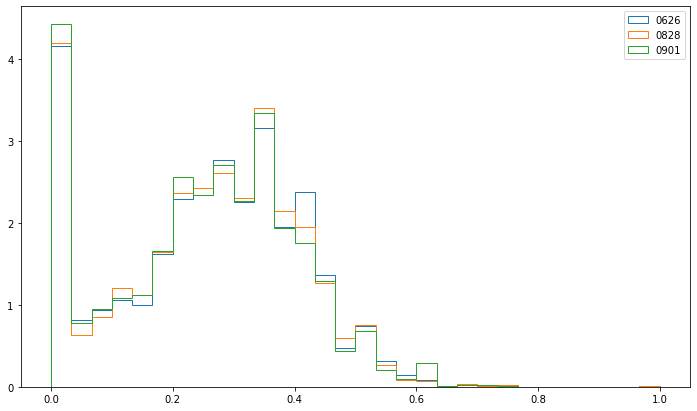

In [254]:
plt.figure(figsize=(12, 7))
plt.hist(stw_prop_0626, bins=30, density=True, label='0626', histtype='step')
plt.hist(stw_prop_0828, bins=30, density=True, label='0828', histtype='step')
plt.hist(stw_prop_0901, bins=30, density=True, label='0901', histtype='step')
plt.legend(loc='best')
plt.show()

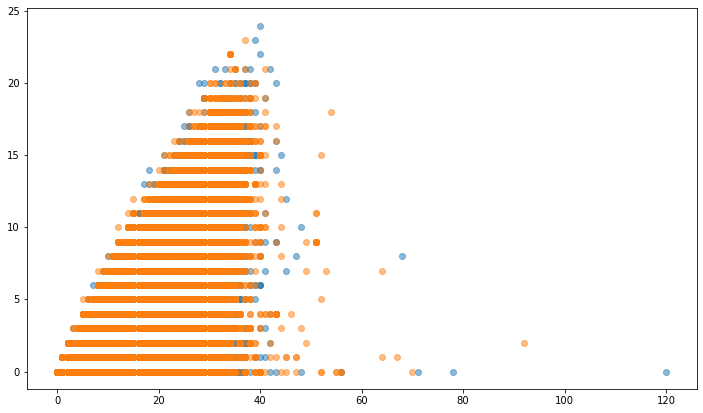

In [259]:
plt.figure(figsize=(12, 7))
plt.scatter(wc_0626, stw_0626, alpha=0.5)
plt.scatter(wc_0901, stw_0901, alpha=0.5)

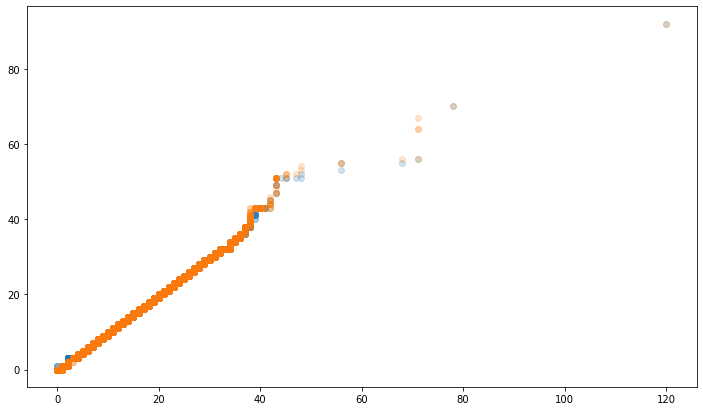

(0.9981235841748215, 0.0)
(0.9980955083598901, 0.0)


In [419]:
# QQ-plot if they come from the same distribution, the QQ-plot should form a straight line
# Wordcount
plt.figure(figsize=(12, 7))
sorted_wc_0626 = sorted(wc_0626)
sorted_wc_0626_larger = sorted(np.random.choice(wc_0626, w_n_obs_0901))
sorted_wc_0901 = sorted(wc_0901)
sorted_wc_0901_smaller = sorted(np.random.choice(wc_0901, w_n_obs_0626, replace=False))
plt.scatter(sorted_wc_0626, sorted_wc_0901_smaller, alpha=0.2)
plt.scatter(sorted_wc_0626_larger, sorted_wc_0901, alpha=0.2)
plt.show()

print(pearsonr(sorted_wc_0626, sorted_wc_0901_smaller))
print(pearsonr(sorted_wc_0626_larger, sorted_wc_0901))

# Calculate the quantile levels of the smaller dataset
quantile_levels1 = np.arange(w_n_obs_0626,dtype=float) / w_n_obs_0626
# Find the quantiles of the larger dataset by linear interpolation
quantiles1 = np.interp(quantile_levels,quantile_levels1,test1)
# Plot the quantiles
pylab.plot(quantiles1,quantiles2)

In [440]:
# Source: https://stackoverflow.com/questions/42658252/how-to-create-a-qq-plot-between-two-samples-of-different-size-in-python

def qqplot(data1, data2, data_sorted_flag=False):
    plt.figure(figsize=(12, 7))
    
    if not data_sorted_flag:
        data1 = sorted(data1)
        data2 = sorted(data2)
    
    sorted_len_data_pairs = sorted([(len(data1), data1), (len(data2), data2)])
    # Calculate the quantile levels
    quantile_levels_smaller = np.arange(sorted_len_data_pairs[0][0],dtype=float) / sorted_len_data_pairs[0][0]
    quantile_levels_larger = np.arange(sorted_len_data_pairs[1][0],dtype=float) / sorted_len_data_pairs[1][0]
    
    # Find the quantiles of the larger dataset by linear interpolation
    quantiles_larger = np.interp(quantile_levels_smaller, quantile_levels_larger, sorted_len_data_pairs[1][1])
    
    # Plot the quantiles
    plt.scatter(quantiles_larger, sorted_len_data_pairs[0][1])
    
    # Add a reference line
    max_val = max(data1[-1], data2[-1])
    min_val = min(data1[0], data2[0])
    plt.plot([min_val, max_val], [min_val, max_val], 'k-', color='red')
    
    plt.show()
    
    print("Pearson correlation coeff: ", pearsonr(quantiles_larger, sorted_len_data_pairs[0][1])[0])

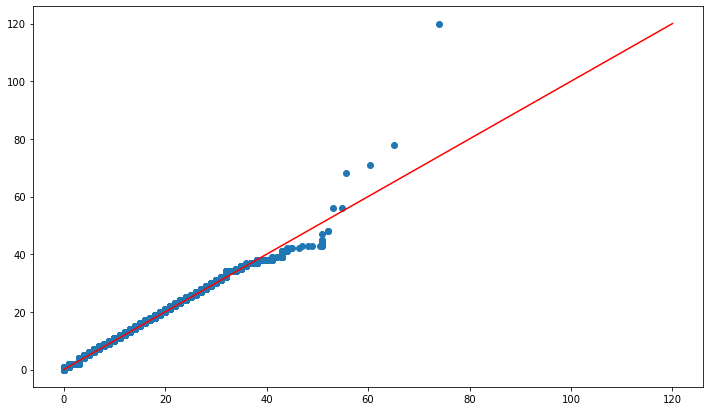

Pearson correlation coeff:  0.99802499398014


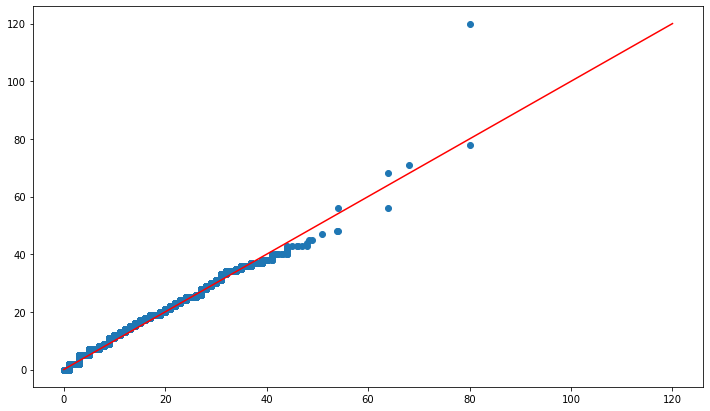

Pearson correlation coeff:  0.9973019342070147


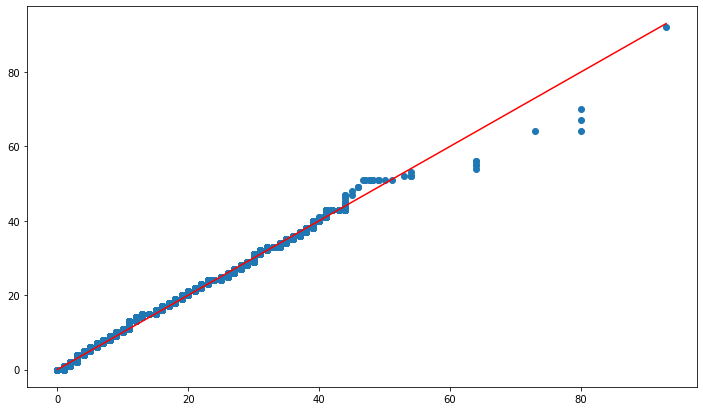

Pearson correlation coeff:  0.9982033576733494


In [441]:
qqplot(sorted_wc_0901, sorted_wc_0626, data_sorted_flag=True)
sorted_wc_0828 = sorted(wc_0828)
qqplot(sorted_wc_0626, sorted_wc_0828, data_sorted_flag=True)
qqplot(sorted_wc_0901, sorted_wc_0828, data_sorted_flag=True)

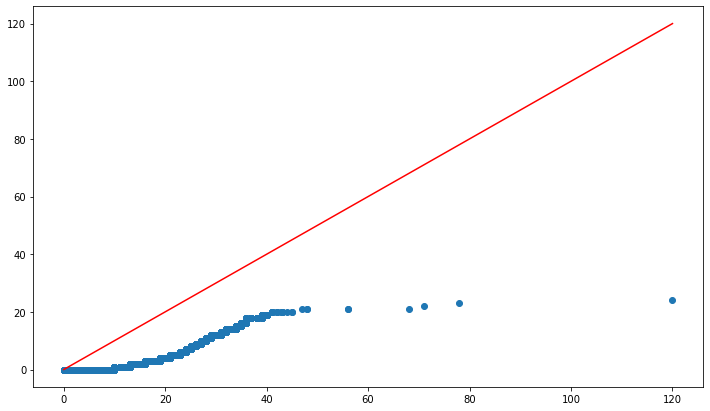

Pearson correlation coeff:  0.9456648228533167


In [655]:
qqplot(stw_prop_0626, stw_prop_0901)

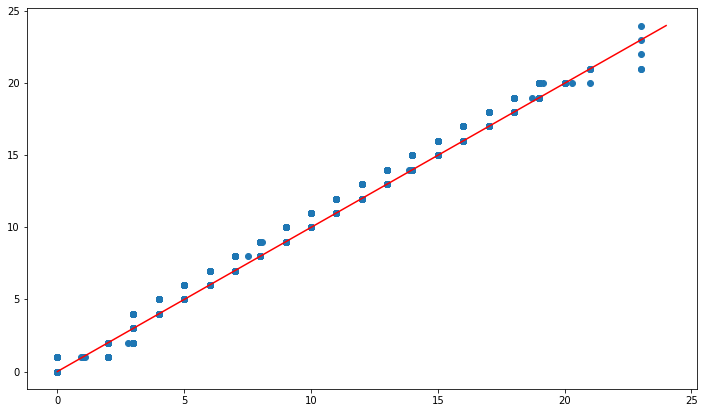

Pearson correlation coeff:  0.996741723637251


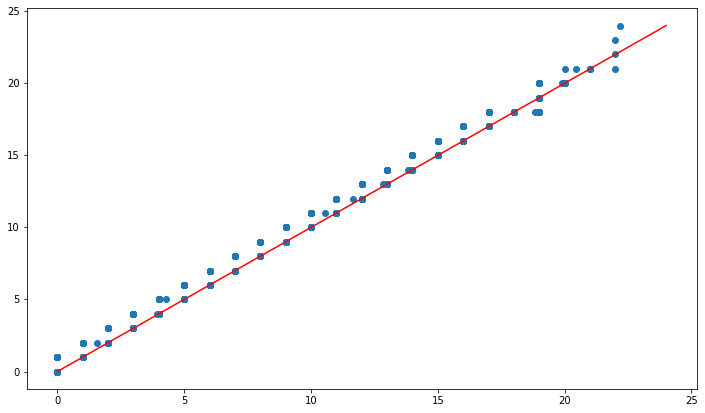

Pearson correlation coeff:  0.9951083767814037


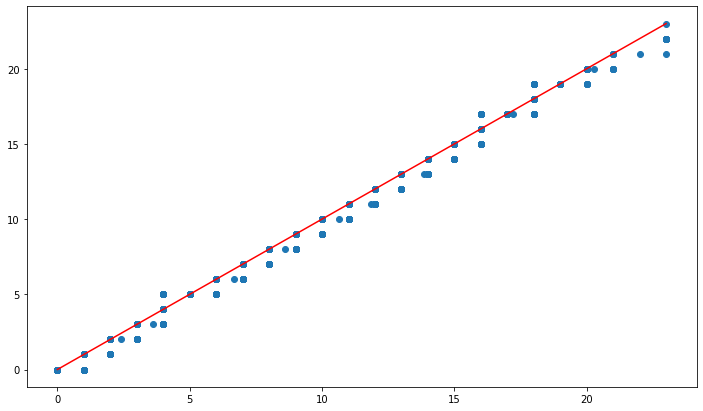

Pearson correlation coeff:  0.9966619867998279


In [442]:
qqplot(stw_0626, stw_0828)
qqplot(stw_0626, stw_0901)
qqplot(stw_0828, stw_0901)

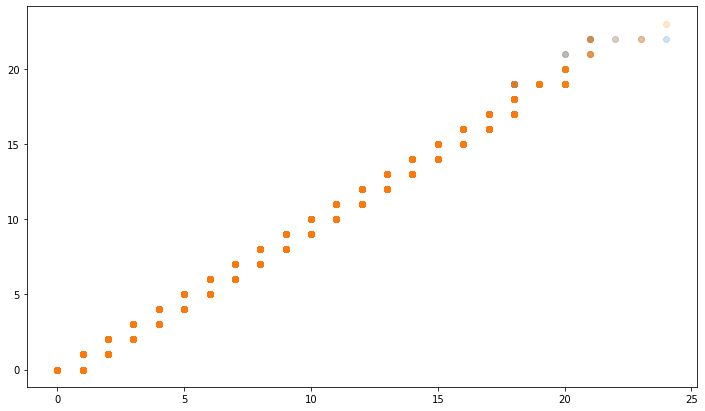

(0.9951397197642733, 0.0)
(0.995008925493112, 0.0)


In [420]:
# QQ-plot if they come from the same distribution, the QQ-plot should form a straight line
# Stopwords
plt.figure(figsize=(12, 7))
sorted_stw_0626 = sorted(stw_0626)
sorted_stw_0626_larger = sorted(np.random.choice(stw_0626, w_n_obs_0901))
sorted_stw_0901 = sorted(stw_0901)
sorted_stw_0901_smaller = sorted(np.random.choice(stw_0901, w_n_obs_0626, replace=False))
plt.scatter(sorted_stw_0626, sorted_stw_0901_smaller, alpha=0.2)
plt.scatter(sorted_stw_0626_larger, sorted_stw_0901, alpha=0.2)
plt.show()

print(pearsonr(sorted_stw_0626, sorted_stw_0901_smaller))
print(pearsonr(sorted_stw_0626_larger, sorted_stw_0901))

<AxesSubplot:title={'center':'Boxplot of stopword proportion per tweet (micro vs. small vs. small)'}>

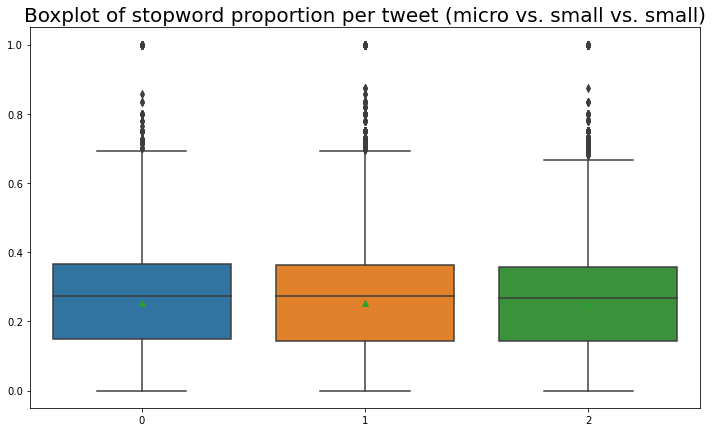

In [652]:
plt.figure(figsize=(12, 7))
plt.title("Boxplot of stopword proportion per tweet (micro vs. small vs. small)", fontsize = 20)
import seaborn as sns
sns.boxplot(
    data=[stw_prop_0626, stw_prop_0828, stw_prop_0901],
    showmeans=True,
)

<AxesSubplot:title={'center':'hi'}>

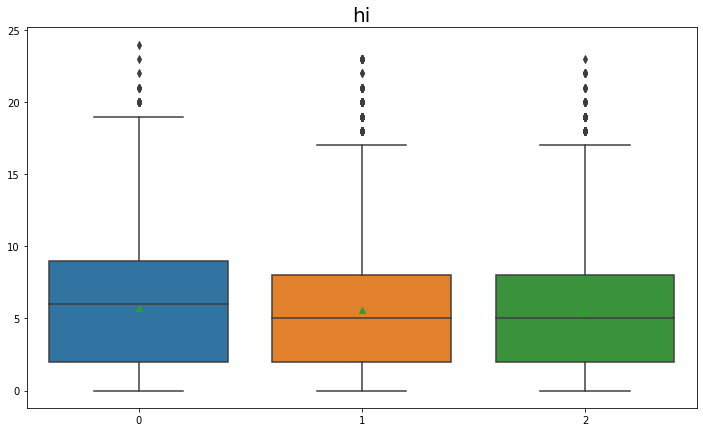

In [650]:
plt.figure(figsize=(12, 7))
plt.title("hi", fontsize = 20)
sns.boxplot(
    data=[stw_0626, stw_0828, stw_0901],
    showmeans=True,
)

<AxesSubplot:title={'center':'Boxplot of tweet wordcount (micro vs. small vs. small)'}>

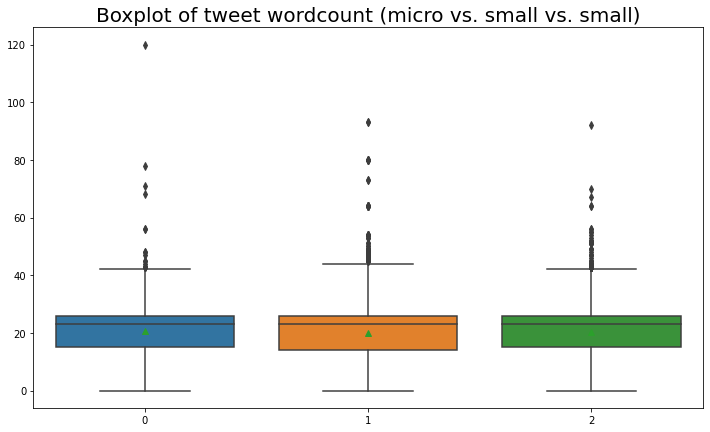

In [651]:
plt.figure(figsize=(12, 7))
plt.title("Boxplot of tweet wordcount (micro vs. small vs. small)", fontsize = 20)
sns.boxplot(
    data=[wc_0626, wc_0828, wc_0901],
    showmeans=True,
)

In [283]:
from scipy.stats import pearsonr
pearsonr([1, 2, 3], [1, 2, 3])

(0.9999999999999998, 1.3415758552508151e-08)

In [307]:
# Bootstrap
wc_mean_tracker_0626 = []
wc_mean_tracker_0901 = []
for i in range(50):
    # 10% resample
    samp_size = int(w_n_obs_0626 * 0.1)
    wc_mean = np.random.choice(wc_0626, samp_size, replace=True).mean()
    # calc the statistic (average wc)
    wc_mean_tracker_0626.append(wc_mean)
    
    samp_size = int(w_n_obs_0901 * 0.1)
    wc_mean = np.random.choice(wc_0901, samp_size, replace=True).mean()
    # calc the statistic (average wc)
    wc_mean_tracker_0901.append(wc_mean)

In [377]:
tweets_0624, tweets_0626, tweets_0825, tweets_0826, tweets_0828, tweets_0829, tweets_0901

-0.004616132792147343

In [382]:
# Each day is a population. We want to bootstrap the different size of samples and see if there is a positive 
# correlation between the large and smaller samples
large_samp_size = n_obs_0624
small_samp_size = int(np.mean([n_obs_0626, n_obs_0825]))
medium_samp_size = int(np.mean([n_obs_0826, n_obs_0828, n_obs_0829, n_obs_0901]))

In [396]:
coefs = []
for j in range(100):
    data_large = []
    data_med = []
    for day_data in [stw_0626, stw_0828, stw_0901]:
        for i in range(10):
            data_large.append(np.random.choice(day_data, large_samp_size, replace=True).mean())
            data_med.append(np.random.choice(day_data, medium_samp_size, replace=True).mean())
        
    coefs.append(pearsonr(data_large, data_med)[0])

# Test for correlation via bootstrapping different sample size on different days

In [397]:
np.mean(coefs)

0.9971425535876299

In [348]:
from scipy.stats import ttest_ind
# num stopwords
# num words
# prop of tweet that is stopwords
tstat, pval = ttest_ind(stw_prop_0828, stw_prop_0901, equal_var=False)
tstat, pval

(14.318975112552573, 1.6975383589138847e-46)

In [213]:
w_n_obs_0626, s_jw_0626 / w_n_obs_0626, s_st_0626 / w_n_obs_0626, s_ast_0626, s_apst_0626

(154000,
 0.04431818181818182,
 0.8621038961038962,
 5.6927792207792205,
 0.254016796382131)

In [214]:
w_n_obs_0828, s_jw_0828 / w_n_obs_0828, s_st_0828 / w_n_obs_0828, s_ast_0828, s_apst_0828

(542000,
 0.037800738007380076,
 0.860350553505535,
 5.579723247232472,
 0.2529527680847816)

In [215]:
w_n_obs_0901, s_jw_0901 / w_n_obs_0901, s_st_0901 / w_n_obs_0901, s_ast_0901, s_apst_0901

(280000,
 0.04418214285714286,
 0.8531321428571429,
 5.4724571428571425,
 0.2478962052354377)

In [401]:
obs = np.array([[s_st_0626, w_n_obs_0626 - s_st_0626], 
                [s_st_0828, w_n_obs_0828 - s_st_0828], 
                [s_st_0901, w_n_obs_0901 - s_st_0901]])
print(obs / np.array([[w_n_obs_0626], [w_n_obs_0828], [w_n_obs_0901]]))
chi2_contingency(obs)

[[0.8621039  0.1378961 ]
 [0.86035055 0.13964945]
 [0.85313214 0.14686786]]


(98.16632344652186,
 4.824515535541128e-22,
 2,
 array([[132217.67827869,  21782.32172131],
        [465337.54303279,  76662.45696721],
        [240395.77868852,  39604.22131148]]))

## Access Google Drive Tool

Need to create API keys and download them as `client_secrets.json` (follow [this tutorial](https://medium.com/@umdfirecoml/a-step-by-step-guide-on-how-to-download-your-google-drive-data-to-your-jupyter-notebook-using-the-52f4ce63c66c)).

In [4]:
import gdrive_quickstart, io
from googleapiclient.http import MediaIoBaseDownload

In [5]:
import importlib
importlib.reload(gdrive_quickstart)

<module 'gdrive_quickstart' from '/Users/sarah/Downloads/TwitterResearch2020/gdrive_quickstart.py'>

In [9]:
DRIVE = gdrive_quickstart.authenticate_drive_api()
file_objs_lst = gdrive_quickstart.get_file_objs_list(DRIVE, 'name contains "combined_tweets-2020"')

In [19]:
tweets_0626 = gdrive_quickstart.download_pkl_file(DRIVE, file_objs_lst[86], print_status=True)
tweets_0921 = gdrive_quickstart.download_pkl_file(DRIVE, file_objs_lst[0], print_status=True)

Download 85%.
Download 100%.
Download 44%.
Download 89%.
Download 100%.


In [535]:
for file_obj in file_objs_lst:
    request = DRIVE.files().get_media(fileId=file_obj['id'])
    fh = io.FileIO(file_obj['name'], mode='w')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))

    thinned_obj_tweets = general_utilities.read_pkl(file_obj['name'])
    # Do something with the `thinned_obj_tweets` or store them to use later

    os.remove(file_obj['name'])
    break

Download 46%.
Download 93%.
Download 100%.


In [557]:
gdrive_quickstart.download_pkl_file(DRIVE, file_objs_lst[0])

Download 46%.
Download 93%.
Download 100%.


 ...]

In [542]:
thinned_obj_tweets_test = gdrive_quickstart.download_pkl_file(file_objs_lst[0], DRIVE)
thinned_obj_tweets_test[0].__dict__

Download 46%.
Download 93%.
Download 100%.


{'tweet_id': '1302099720249257984',
 'text': 'RT @KellyannePolls: Aug 2020 8.4% unemployment (with pandemic)\nAug 2012  8.1%  unemployment (Biden VP, no pandemic)',
 'hashtags': [],
 'mentions': [{'screen_name': 'KellyannePolls',
   'name': 'Kellyanne Conway',
   'id': 471672239,
   'id_str': '471672239',
   'indices': [3, 18]}],
 'user': <thinned_tweet_obj.tweet_user at 0x7fe5bd3c7a10>,
 'retweet': <thinned_tweet_obj.tweet at 0x7fe5e9674310>,
 'retweet_count': 0,
 'in_reply': '',
 'quote': None,
 'quote_status': True,
 'favorited': False,
 'favorite_count': 0}

In [537]:
thinned_obj_tweets[1].__dict__

{'tweet_id': '1302099720496648199',
 'text': 'RT @Kastia: This is the energy I want to have during 2020 and beyond. https://t.co/rq9oYDVQZe',
 'hashtags': [],
 'mentions': [{'screen_name': 'Kastia',
   'name': 'Kaitlin 🍅End White Supremacy🍅',
   'id': 14365564,
   'id_str': '14365564',
   'indices': [3, 10]}],
 'user': <thinned_tweet_obj.tweet_user at 0x7fe5bd53c850>,
 'retweet': <thinned_tweet_obj.tweet at 0x7fe5bd53c890>,
 'retweet_count': 0,
 'in_reply': '',
 'quote': None,
 'quote_status': False,
 'favorited': False,
 'favorite_count': 0}

In [516]:
file_objs_lst

[{'kind': 'drive#file',
  'id': '1BeliQpW2Lmg4kckqI9iN1CDHqkVorAoC',
  'name': 'combined_tweets-2020-09-05.pkl',
  'mimeType': 'application/octet-stream'},
 {'kind': 'drive#file',
  'id': '1uLS5XEtjA4bgvVskgQy0TeuMaGSsebSN',
  'name': 'combined_tweets-2020-09-04.pkl',
  'mimeType': 'application/octet-stream'},
 {'kind': 'drive#file',
  'id': '1LQ48j2qk2eeqyMHfjlGa6kPMslJNXHHI',
  'name': 'combined_tweets-2020-09-03.pkl',
  'mimeType': 'application/octet-stream'},
 {'kind': 'drive#file',
  'id': '12TSR36JjRHjCUYJjMqC-xt-1nP4utUpN',
  'name': 'combined_tweets-2020-09-02.pkl',
  'mimeType': 'application/octet-stream'},
 {'kind': 'drive#file',
  'id': '171LpmfVcraVJ1KpgQLuyIrnmDEaLA-1A',
  'name': 'combined_tweets-2020-09-01.pkl',
  'mimeType': 'application/octet-stream'},
 {'kind': 'drive#file',
  'id': '1jrw7f-tsv5nJ3abl5SV0Gdp5HwcUvB26',
  'name': 'combined_tweets-2020-08-31.pkl',
  'mimeType': 'application/octet-stream'},
 {'kind': 'drive#file',
  'id': '1c8Slfc05wSMuavqZyDyFvtzbXUHmDk

## Bootstrap

In [630]:
# Bootstrap vs. binomial for proportions
# b = np.random.choice(rt_0901, size=n_obs_0624, replace=True)
a = np.random.binomial(n_obs_0624, s_rt_0901 / n_obs_0901, 10000)
c = np.random.binomial(n_obs_0901, s_rt_0901 / n_obs_0901, 10000)

day1_med = np.random.binomial(n_obs_0901, s_rt_0624 / n_obs_0624, 100) / n_obs_0901
day1_l = np.random.binomial(n_obs_0624, s_rt_0624 / n_obs_0624, 100) / n_obs_0624
day2_med = np.random.binomial(n_obs_0901, s_rt_0828 / n_obs_0828, 100) / n_obs_0901
day2_l = np.random.binomial(n_obs_0624, s_rt_0828 / n_obs_0828, 100) / n_obs_0624
day3_med = np.random.binomial(n_obs_0901, s_rt_0901 / n_obs_0901, 100) / n_obs_0901
day3_l = np.random.binomial(n_obs_0624, s_rt_0901 / n_obs_0901, 100) / n_obs_0624
day4_med = np.random.binomial(n_obs_0901, s_rt_0829 / n_obs_0829, 100) / n_obs_0901
day4_l = np.random.binomial(n_obs_0624, s_rt_0829 / n_obs_0829, 100) / n_obs_0624
day5_med = np.random.binomial(n_obs_0901, s_rt_0826 / n_obs_0826, 100) / n_obs_0901
day5_l = np.random.binomial(n_obs_0624, s_rt_0826 / n_obs_0826, 100) / n_obs_0624

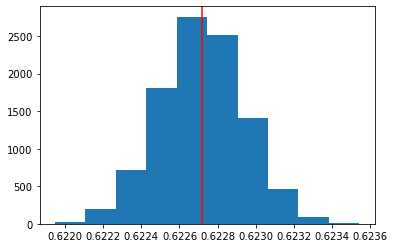

In [594]:
plt.hist(a / n_obs_0624)
plt.axvline(x = s_rt_0901 / n_obs_0901, color = "red")

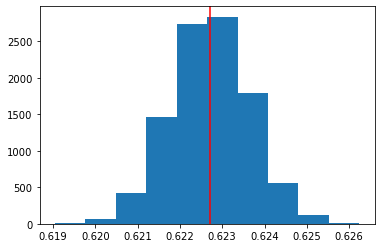

In [595]:
plt.hist(c / n_obs_0901)
plt.axvline(x = s_rt_0901 / n_obs_0901, color = "red")

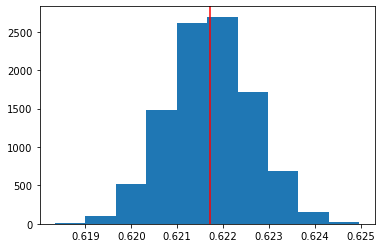

In [597]:
plt.hist(d / n_obs_0901)
plt.axvline(x = s_rt_0624 / n_obs_0624, color = "red")

In [631]:
days_med = list(day1_med) + list(day2_med) + list(day3_med) + list(day4_med) + list(day5_med)
days_l = list(day1_l) + list(day2_l) + list(day3_l) + list(day4_l) + list(day5_l)

(0.9952191203639282, 9.6051214214852e-25)

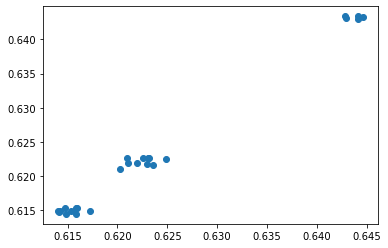

In [632]:
plt.scatter(days_med, days_l)
pearsonr(days_med, days_l)

In [561]:
s_rt_0901 / n_obs_0901
# n_obs_0624

0.6227178571428571

In [568]:
rt_0901 = [1] * s_rt_0901 + [0] * (n_obs_0901 - s_rt_0901)

(280000, 280000)

## QQ-Plot tool

In [23]:
# Source: https://stackoverflow.com/questions/42658252/how-to-create-a-qq-plot-between-two-samples-of-different-size-in-python

def qqplot(data1, data2, data_sorted_flag=False):
    plt.figure(figsize=(12, 7))
    
    if not data_sorted_flag:
        data1 = sorted(data1)
        data2 = sorted(data2)
    
    sorted_len_data_pairs = sorted([(len(data1), data1), (len(data2), data2)])
    # Calculate the quantile levels
    quantile_levels_smaller = np.arange(sorted_len_data_pairs[0][0],dtype=float) / sorted_len_data_pairs[0][0]
    quantile_levels_larger = np.arange(sorted_len_data_pairs[1][0],dtype=float) / sorted_len_data_pairs[1][0]
    
    # Find the quantiles of the larger dataset by linear interpolation
    quantiles_larger = np.interp(quantile_levels_smaller, quantile_levels_larger, sorted_len_data_pairs[1][1])
    
    # Plot the quantiles
    plt.scatter(quantiles_larger, sorted_len_data_pairs[0][1])
    
    # Add a reference line
    max_val = max(data1[-1], data2[-1])
    min_val = min(data1[0], data2[0])
    plt.plot([min_val, max_val], [min_val, max_val], 'k-', color='red')
    
    plt.show()
    
    print("Pearson correlation coeff: ", pearsonr(quantiles_larger, sorted_len_data_pairs[0][1])[0])

In [36]:
# Stopwords - one possible metric

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import pearsonr

stop_words = set(stopwords.words('english'))

def get_stopword_trackers(obj_lst):
    n_obs = 0
    
    # number of stopwords per tweet
    stopwords_tracker = []
    # avg proportion of stopwords per tweet
    stopwords_prop_tracker = []
    wordcount_tracker = []
    for thin_obj in obj_lst:
        n_obs += 1
        if thin_obj.is_retweet: 
            # Reassign the thin_obj so that we look at the retweet's text
            thin_obj = thin_obj.retweet
            
        word_tokens = word_tokenize(thin_obj.text)
        stopword_count = 0
        for w in word_tokens:
            w = w.lower()
            if w in stop_words: 
                stopword_count += 1
        stopwords_tracker.append(stopword_count)
        num_words = len(word_tokens)
        
        stopwords_prop_tracker.append(stopword_count / num_words if num_words else 0)
        wordcount_tracker.append(num_words)
            
    return n_obs, stopwords_tracker, stopwords_prop_tracker, wordcount_tracker


def print_qqplots_from_obj_lst(obj_lst1, obj_lst2):
    n_obs1, stopwords_tracker1, stopwords_prop_tracker1, wordcount_tracker1 = get_stopword_trackers(obj_lst1)
    n_obs2, stopwords_tracker2, stopwords_prop_tracker2, wordcount_tracker2 = get_stopword_trackers(obj_lst2)
    
    print(f"Stopwords QQ-Plot")
    qqplot(stopwords_tracker1, stopwords_tracker2)
    
    print(f"\nStopword Proportion QQ-Plot")
    qqplot(stopwords_tracker1, stopwords_tracker2)
    
    print(f"\nWordcount QQ-Plot")
    qqplot(stopwords_tracker1, stopwords_tracker2)
    
    
def print_qqplots_from_trackers(stopwords1, stopwords_prop1, wordcount1, stopwords2, stopwords_prop2, wordcount2):
    print(f"Stopwords QQ-Plot")
    qqplot(stopwords1, stopwords2)
    
    print(f"\nStopword Proportion QQ-Plot")
    qqplot(stopwords_prop1, stopwords_prop2)
    
    print(f"\nWordcount QQ-Plot")
    qqplot(wordcount1, wordcount2)

In [31]:
n_obs_0626, stw_0626, stw_p_0626, wc_0626 = get_stopword_trackers(tweets_0626)
n_obs_0921, stw_0921, stw_p_0921, wc_0921 = get_stopword_trackers(tweets_0921)

Stopwords QQ-Plot


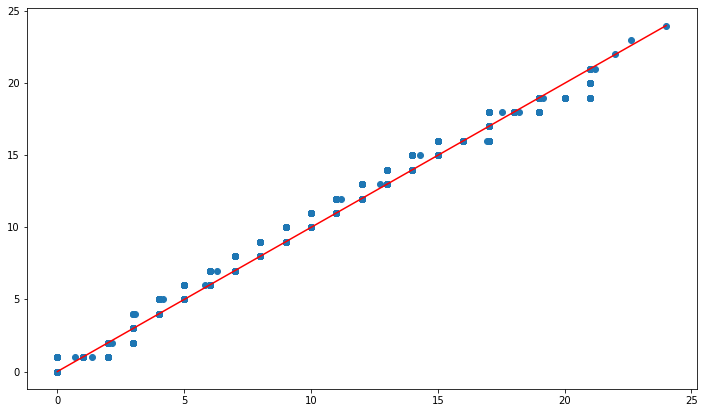

Pearson correlation coeff:  0.9980117384787731

Stopword Proportion QQ-Plot


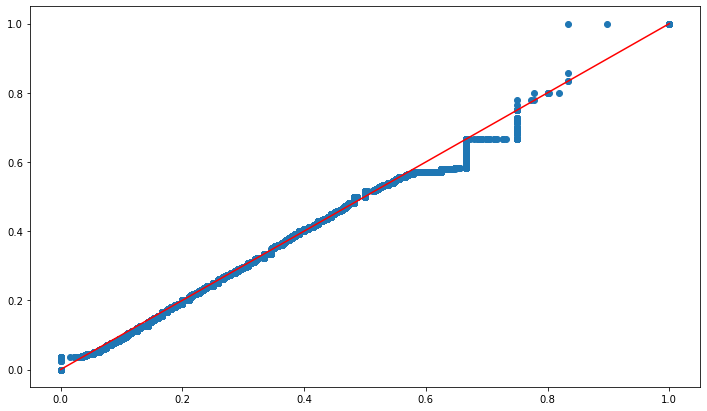

Pearson correlation coeff:  0.9989679336037212

Wordcount QQ-Plot


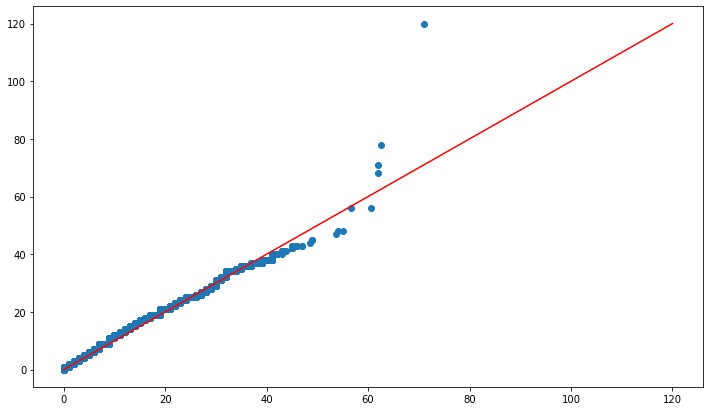

Pearson correlation coeff:  0.9970394911358726


In [37]:
print_qqplots_from_trackers(stw_0626, stw_p_0626, wc_0626, stw_0921, stw_p_0921, wc_0921)

In [44]:
import stat_analysis
import importlib
importlib.reload(stat_analysis)

<module 'stat_analysis' from '/Users/sarah/Downloads/TwitterResearch2020/stat_analysis.py'>

Stopwords QQ-Plot


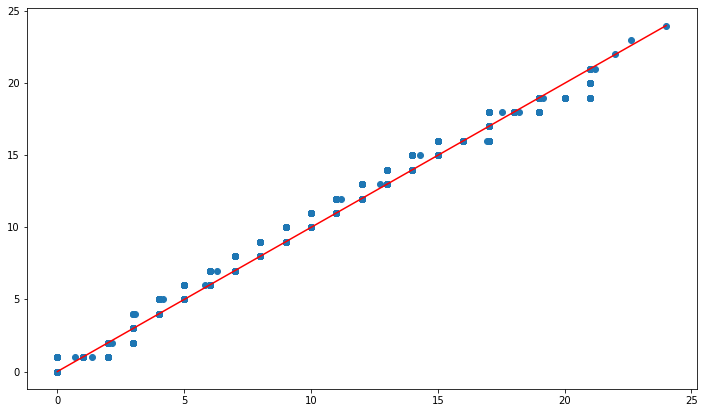

Pearson correlation coeff:  0.9980117384787731

Stopword Proportion QQ-Plot


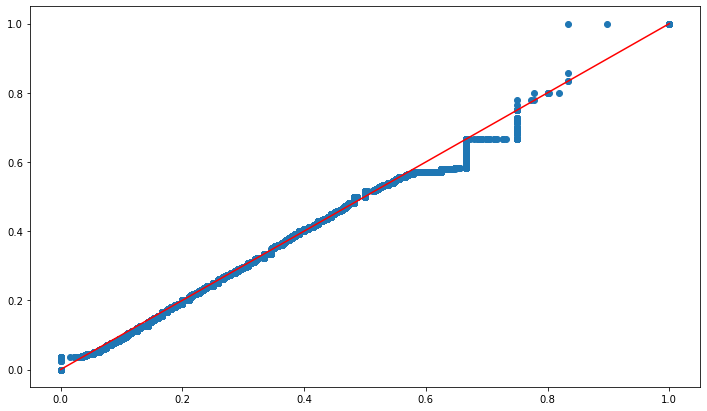

Pearson correlation coeff:  0.9989679336037212

Wordcount QQ-Plot


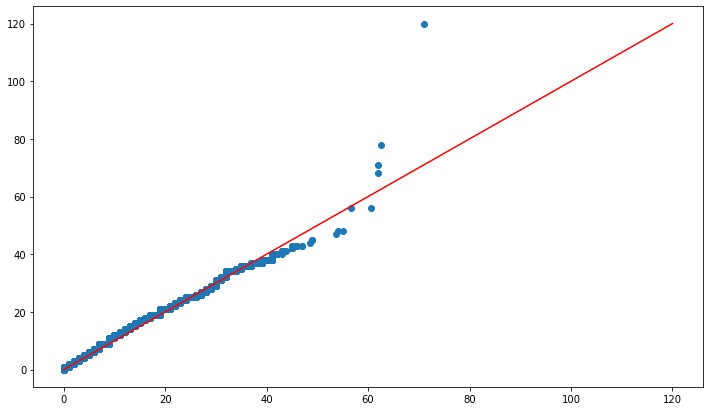

Pearson correlation coeff:  0.9970394911358726


In [45]:
stat_analysis.print_qqplots_from_trackers(stw_0626, stw_p_0626, wc_0626, stw_0921, stw_p_0921, wc_0921)